In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

#If our module is not on the path then add it before trying an import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from openpolicedata import *

print(sys.path)
print(dir())

['/home/user/cjc/openpolicedata/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/user/cjc/openpolicedata/.venv/lib/python3.8/site-packages', '/home/user/cjc/openpolicedata/.venv/lib/python3.8/site-packages/IPython/extensions', '/home/user/.ipython', '/home/user/.local/lib/python3.8/site-packages', '/home/user/cjc/openpolicedata']
['DataTypes', 'In', 'Out', 'Point', 'Polygon', 'Source', 'TableTypes', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'data', 'data_loaders', 'datasets', 'exit', 'get', 'get_ipython', 'gpd', 'module_path', 'os', 'pd', 'plt', 'quit', 'site', 'sys']


In [3]:
#  For the example load one years worth of data
source=Source("Denver")
tables=source.load_from_url(2018)
#show the columns
tables.table.head(1)

,geometry,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID
0,POINT (3161186.535 1634255.405),3077581,DPD-18-0214276,P3 Public Need,Vehicle Stop,S Forest St / S Glencoe Way,2,2018-03-31 21:32:11,Party Advised,3161186.53,1634255.4,-104.92819,39.573423,None,None,None,34f94a53-0fc3-4390-bf7e-fb0cc5b47dcf


In [13]:
tables.table['geometry']=tables.table['geometry'].to_crs(crs='EPSG:4326')

In [21]:
df=tables.table
df.head(3)

,geometry,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID
0,POINT (-105.09952 39.56952),3077577,DPD-13-0233909,P3 Public Need,Subject Stop,8086 S Flower St,2,1970-01-01 00:22:49.480696,File Only,3112899.29,1632571.97,-105.099513,39.569511,None,None,None,c2949d0a-5d06-40a7-b1bf-1a732497fd38
1,POINT (-105.04938 39.58133),3077594,DPD-13-0037678,P3 Public Need,Vehicle Stop,W Hinsdale Ct / S Wolff St,2,1970-01-01 00:22:38.989412,T - Citation Issued,3127012.26,1636939.92,-105.049374,39.581321,None,None,None,e4df41e0-5bbd-4f67-b9c1-ce3c3afbf531
2,POINT (-105.08204 39.58251),3077595,DPD-13-0544413,P3 Public Need,Vehicle Stop,7390 S Webster St,2,1970-01-01 00:23:04.167736,Vehicle Towed,3117807.14,1637326.81,-105.082026,39.582504,None,None,None,47add278-c88f-4a4c-82c5-4924c6628b33


In [ ]:
#If you don't have the shape file saved
# import requests
res = requests.get('https://www.denvergov.org/media/gis/DataCatalog/police_districts/shape/police_districts.zip')
res.raise_for_status()
 

In [6]:
# Now load the shape file
#https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-police-districts
#download https://www.denvergov.org/media/gis/DataCatalog/police_districts/shape/police_districts.zip into data
#Following this example https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
from pathlib import Path
import os
homeFolder = Path('..')

import requests
police_districts_base_filename = 'police_districts'
police_districts_zip_filename = police_districts_base_filename + ".zip"
police_districts_dir = homeFolder / 'data' / police_districts_base_filename
police_districts_zip_full_filename =  police_districts_dir / police_districts_zip_filename
os.makedirs(police_districts_dir)
res = requests.get( r'https://www.denvergov.org/media/gis/DataCatalog/police_districts/shape/' + police_districts_zip_filename )
res.raise_for_status()
print(f"Downloading " + police_districts_zip_filename)
with open(police_districts_zip_full_filename, 'wb') as f:
    print(".",end='',flush=True)
    f.write(res.content)


.

In [7]:
import zipfile

police_districts_zip = zipfile.ZipFile(police_districts_zip_full_filename)
print(police_districts_zip.namelist())
police_districts_zip.extractall(police_districts_dir)
police_districts_zip.close()

['police_districts.dbf', 'police_districts.prj', 'police_districts.sbn', 'police_districts.sbx', 'police_districts.shp', 'police_districts.shp.xml', 'police_districts.shx']


<AxesSubplot:>

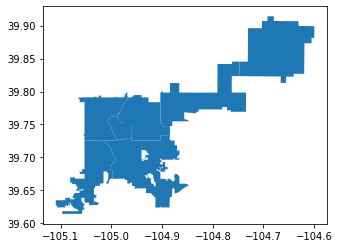

In [8]:
police_districts_shp_filename = police_districts_base_filename + ".shp"
police_districts_shp_full_filename =  police_districts_dir / police_districts_shp_filename
map_df = gpd.read_file(police_districts_shp_full_filename)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()
map_df.plot()

epsg:4326


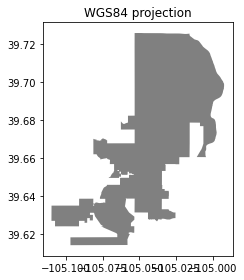

In [15]:
print(map_df.crs)
total_districts = set(map_df["DIST_NUM"])

district_map = [map_df[current_district==map_df["DIST_NUM"]] for current_district in total_districts]
district_map[2].plot(facecolor='gray')

# Add title
plt.title("WGS84 projection")

# Remove empty white space around the plot
plt.tight_layout()


In [17]:
#https://geopandas.org/en/stable/gallery/spatial_joins.html
map_df['DIST_NUM']

0    6
1    1
2    7
3    4
4    3
5    5
6    2
Name: DIST_NUM, dtype: object

In [6]:
map_df.head()

,DIST_NUM,SHAPE_Leng,SHAPE_Area,geometry
0,6,0.159844,0.001126,"POLYGON ((-104.97812 39.75116, -104.97812 39.7..."
1,1,0.379425,0.004253,"POLYGON ((-104.97165 39.79832, -104.96874 39.7..."
2,7,0.494029,0.009891,"POLYGON ((-104.66854 39.90689, -104.65921 39.9..."
3,4,0.745554,0.005468,"POLYGON ((-105.04779 39.72564, -105.04685 39.7..."
4,3,0.996035,0.009227,"MULTIPOLYGON (((-104.88470 39.73284, -104.8847..."


In [18]:
dir(tables.table)

['ADDRESS',
 'CALL_CLASS',
 'CALL_DISPOSITION',
 'CachedAccessor',
 'DISTRICT_ID',
 'GEO_LAT',
 'GEO_LON',
 'GEO_X',
 'GEO_Y',
 'GLOBALID',
 'MASTER_INCIDENT_NUMBER',
 'NEIGHBORHOOD_NAME',
 'OBJECTID',
 'PRECINCT_ID',
 'PRIORITY_DESCRIPTION',
 'PROBLEM',
 'T',
 'TIME_PHONEPICKUP',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '

In [22]:
point_list = df['geometry'].tolist()
point_region_list=[]
for this_point in point_list:
    region_list=[]
    for idx in range(len(district_map)):
        if district_map[idx].contains(this_point).bool():
            region_list.append(idx)
    point_region_list.append(region_list)


In [23]:
point_region_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [],
 [],
 [2],
 [2],
 [2],
 [2],
 [],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [],
 [2],
 [2],
 [2],
 [2],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [2],
 [2],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [6],
 [2],
 [2],
 [],
 [],
 [2],
 [6],
 [6],
 [6],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [6],
 [6],
 [6],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2

In [24]:
df['REGION_IDX'] = df['geometry'].apply(lambda x: [ idx  for idx in range(len(district_map)) if district_map[idx].contains(x).bool()])

In [40]:
mask=df['REGION_IDX'].apply(lambda x: 2 in x)


13411

Text(50.375, 0.5, 'Latitude')

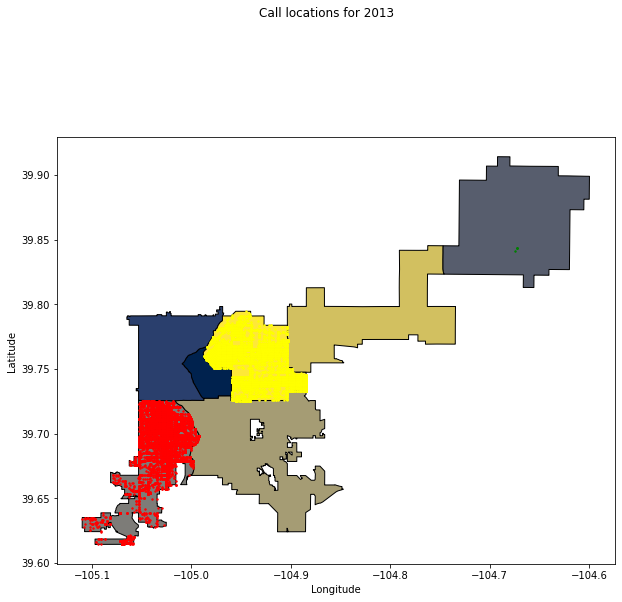

In [42]:
fig, ax = plt.subplots(figsize=(10,10))

map_df.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")

#You can use different 'cmaps' such as jet, plasm,magma, infereno,cividis, binary...(I simply chose cividis)
for plot_color in [(2,'red'), (3, 'green'), (4,'yellow')]:
    mask=df['REGION_IDX'].apply(lambda x: plot_color[0] in x)
    df[mask].plot(ax=ax, color=plot_color[1], markersize=2)

fig.suptitle('Call locations for 2013', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')
